Files already downloaded and verified
Files already downloaded and verified
Network(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Epoch: 0 	Training Loss: 2.103717 	Validation Loss: 1.747523
Validation loss decreased (inf --> 1.747523).  Saving model ...
Epoch: 1 	Training Loss: 1.563781 	Validation Loss: 1.296160
Validation loss decreased (1.747523 --> 1.296160).  Saving model ...
Epoch: 2 	Training Loss: 1.221744 	Validation Loss: 1.076179
Validation loss decreased (1.296160 --> 1.076179). 

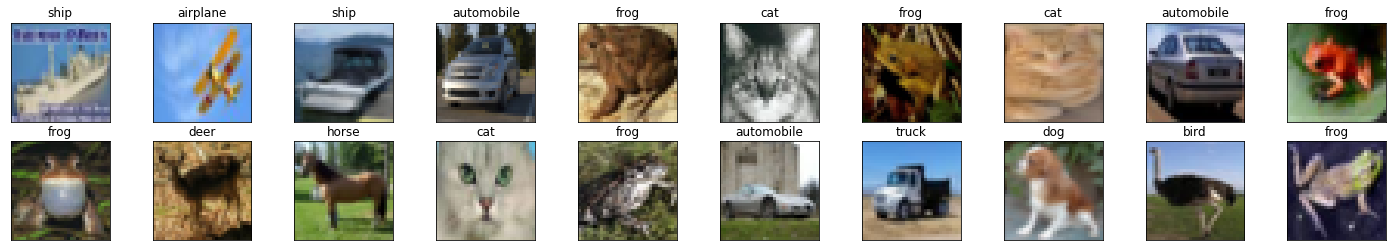

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 11 22:22:07 2020

@author: sabih
"""

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,48,3,padding=1)
        self.conv2=nn.Conv2d(48,96,3,padding=1)
        self.conv3=nn.Conv2d(96,192,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.dropout=nn.Dropout(0.25)
        self.fc1=nn.Linear(192*4*4,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,10)        
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x=x.view(-1,192*4*4)
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=F.relu(self.fc3(x))
        return x

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

num_workers = 0
batch_size = 20
valid_size = 0.2

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ])
train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform)

n=len(train_data)
indices=list(range(n))
np.random.shuffle(indices)
split=int(np.floor(n*valid_size))
train_ind,valid_ind=indices[split:],indices[:split]

train_samp=SubsetRandomSampler(train_ind)
valid_samp=SubsetRandomSampler(valid_ind)

train_loader=torch.utils.data.DataLoader(train_data,sampler=train_samp,batch_size=batch_size,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,sampler=valid_samp,batch_size=batch_size,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers,shuffle=True)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

model=Network()
print(model)
if train_on_gpu:
    model.cuda()

criterian=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.03)

epochs=30
valid_loss_min = np.Inf 
train_losses=[]
valid_losses=[]
for i in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for image,label in train_loader:
        if train_on_gpu:
            image, label = image.cuda(), label.cuda()
        optimizer.zero_grad()
        output=model(image)
        loss=criterian(output,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image.size(0)
    model.eval()
    for image,label in valid_loader:
        if train_on_gpu:
            image, label = image.cuda(), label.cuda()
        output = model(image)
        loss = criterian(output, label)
        valid_loss += loss.item()*image.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

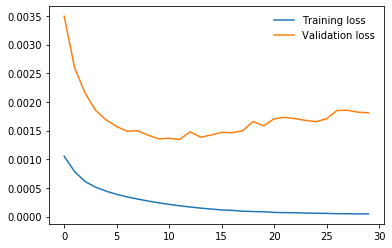

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 
x = np.linspace(-10 , 10, 100)
y = np.sin(x) 
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [9]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterian(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.938860

Test Accuracy of airplane: 81% (813/1000)
Test Accuracy of automobile: 89% (896/1000)
Test Accuracy of  bird: 64% (645/1000)
Test Accuracy of   cat: 60% (602/1000)
Test Accuracy of  deer: 75% (758/1000)
Test Accuracy of   dog: 68% (685/1000)
Test Accuracy of  frog: 88% (881/1000)
Test Accuracy of horse: 85% (856/1000)
Test Accuracy of  ship: 84% (840/1000)
Test Accuracy of truck: 84% (845/1000)

Test Accuracy (Overall): 78% (7821/10000)


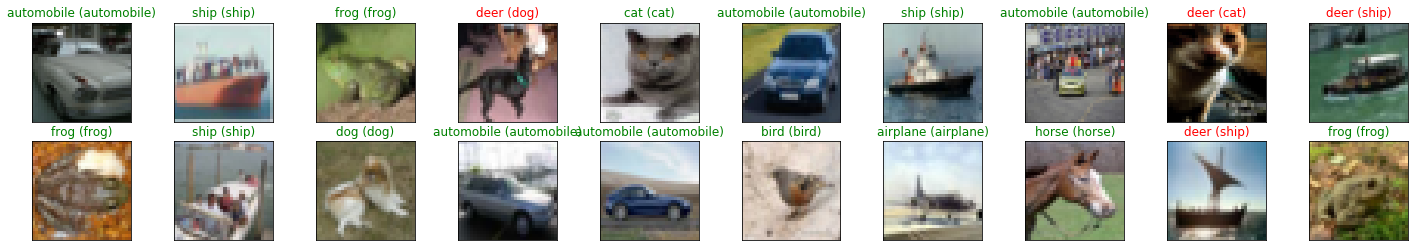

In [18]:
# obtain one batch of test images
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers,shuffle=True)
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))